In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# 1.0 Data retrieval

In [448]:
df = pd.read_pickle('../../data_lake/output/2_dp.pkl')

In [449]:
df.sample(1)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
SegFile,,,,,,,,,,,,,,,,,,,,,,,,
CTG1209.txt,136.0,136.0,3.0,0.0,6.0,48.0,0.7,2.0,9.4,0.0,0.0,0.0,42.0,121.0,163.0,1.0,1.0,144.0,144.0,145.0,2.0,0.0,2.0,1.0


In [450]:
# df = df.drop(columns='CLASS')

In [451]:
for i in df:
    if df[i].dtype == 'object':
        df[i] = df[i].astype(str)

In [452]:
df1 = df

In [453]:
df1['NSP'] = df['NSP'].mask((df['NSP'] == '1.0') | (df['NSP'] == '3.0'),'0.0')

In [454]:
df1['NSP'].value_counts()

0.0    1831
2.0     295
Name: NSP, dtype: int64

In [455]:
df_under = df1[df1['NSP']=='2.0']
df_over = df1[df1['NSP']=='0.0']
df_over = df_over.sample(frac=df_under.shape[0]/df_over.shape[0],random_state=0)
df2 = df_over.append(df_under).sample(frac=1)

In [456]:
df2['NSP'].value_counts()

2.0    295
0.0    295
Name: NSP, dtype: int64

In [457]:
# df2['NSP'] = df2['NSP'].mask(df2['NSP']=='3.0','1.0')

In [458]:
X = df2.drop(columns=['NSP'])
y = df2[['NSP']]

In [459]:
# pip install catboost

In [460]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier

In [461]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.4, random_state = 1)

In [462]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [463]:
# numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
#                                      ("scaler", MinMaxScaler())])
categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                       ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
                                           ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
# preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
#                                            ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])

In [464]:
# pipe_model = CatBoostClassifier(iterations=500, 
#                            loss_function='Logloss', 
#                            eval_metric='Accuracy',
#                            verbose=False,
#                            early_stopping_rounds=50,
#                            depth=3,
#                            random_state=1)

In [484]:
pipe_model = GradientBoostingClassifier(max_depth=4,n_estimators=3, random_state=1)

In [485]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])

In [486]:
model.fit(X_train,y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('label_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Tendency', 'CLASS'], dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(max_depth=4, n_estimators=3,
                                            random_state=1))])

In [487]:
# parameters = {'model__depth':[2,3],'model__iterations':[500,1000]}

In [488]:
parameters = {}

In [489]:
# k = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)

In [490]:
# from sklearn.metrics import precision_score, make_scorer
# custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label=1)

In [491]:
model_grid = GridSearchCV(model,parameters,cv=3,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
print('GridSearchCV results...')
print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
print("Mean Test Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))

GridSearchCV results...
Mean Train Scores: 
[0.94774011]

Mean Test Scores: 
[0.91525424]



/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return

In [492]:
print('Test results...')
y_test_predict_grid = model_grid.predict(X_test)

Test results...


Model Test Accuracy: 0.9533898305084746
--------------------------------------------------
Model Test Confusion Matrix


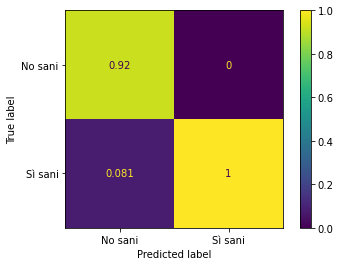

In [493]:
print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print('Model Test Confusion Matrix')
cm = confusion_matrix(y_test,y_test_predict_grid,normalize='pred') 
cmd = ConfusionMatrixDisplay(cm,display_labels=['No sani','Sì sani'])
cmd.plot()

In [439]:
feature_importances = model_grid.best_estimator_.named_steps['model'].get_feature_importance()
feature_names = X_train.columns
lista = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        print('{}: {}'.format(name, score))
        lista.append(name)
print('Di seguito le prime 10 features per importanza:')
print(lista[0:10])

ASTV: 66.58939411742841
DL: 25.229613499959047
MSTV: 4.1128679233226295
DP: 1.8283980543645832
DS: 1.0757687998006678
UC: 0.4597369508751507
Nzeros: 0.14090957544315869
FM: 0.13723028921644737
Tendency: 0.12611973319491568
LBE: 0.10882502253349219
AC: 0.07852075618652037
MLTV: 0.06854551763947735
ALTV: 0.044069760035521696


In [494]:
df['proba1'] = 0
df['proba1'] = model_grid.predict_proba(df[X_test.columns])[:,1]

In [495]:
df.sample(1)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP,proba1
SegFile,,,,,,,,,,,,,,,,,,,,,,,,,
CTG0037.txt,115.0,115.0,6.0,95.0,6.0,23.0,3.4,0.0,18.8,3.0,0.0,0.0,130.0,52.0,182.0,9.0,0.0,119.0,116.0,118.0,21.0,0.0,6.0,0.0,0.381293


<AxesSubplot:>

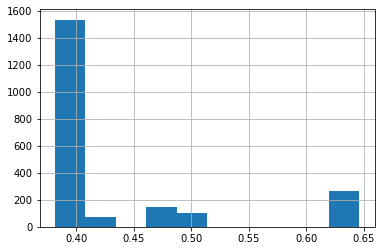

In [496]:
df['proba1'].hist()

<AxesSubplot:>

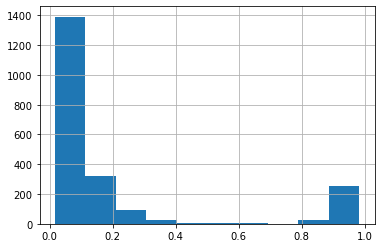

In [54]:
df['proba1'].hist()

<AxesSubplot:>

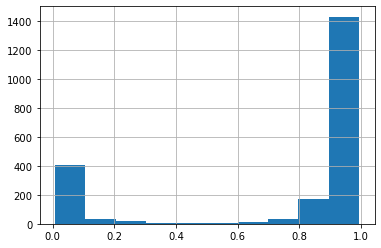

In [28]:
df['proba1'].hist()

In [115]:
steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('pca', PCA(n_components=2)))
steps.append(('model', GradientBoostingClassifier(max_depth=1,n_estimators=3, random_state=1)))
# steps.append(('model', RandomForestClassifier(max_depth=2,n_estimators=3, random_state=1)))
pipeline_accumulation = Pipeline(steps=steps)

In [116]:
parameters = {}

In [117]:
k = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
model_accumulation = GridSearchCV(pipeline_accumulation,param_grid=parameters,cv=k,scoring='accuracy').fit(X_train, y_train)

In [118]:
print("Best Estimator: \n{}\n".format(model_accumulation.best_estimator_))
print("Best Parameters: \n{}\n".format(model_accumulation.best_params_))
print("Best Test Score: \n{}\n".format(model_accumulation.best_score_))
print("Mean Test Scores: \n{}\n".format(model_accumulation.cv_results_['mean_test_score']))

Best Estimator: 
Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('model',
                 GradientBoostingClassifier(max_depth=1, n_estimators=3,
                                            random_state=1))])

Best Parameters: 
{}

Best Test Score: 
1.0

Mean Test Scores: 
[1.]



Model Test Recall: 1.0
--------------------------------------------------
Model Test Precision: 1.0
--------------------------------------------------
Model Test F1: 1.0
--------------------------------------------------
Model Test Accuracy: 1.0
--------------------------------------------------
Model Confusion Matrix


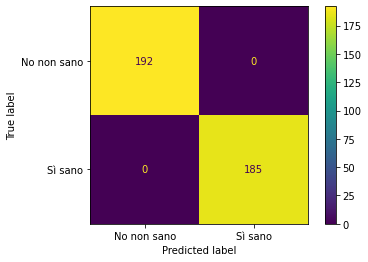

In [119]:
y_test_predict_grid = model_accumulation.predict(X_test)
print("Model Test Recall:", metrics.recall_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test Precision:", metrics.precision_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test F1:", metrics.f1_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
print('--------------------------------------------------')
print('Model Confusion Matrix')
cm = confusion_matrix(y_test,y_test_predict_grid,normalize=None) 
cmd = ConfusionMatrixDisplay(cm,display_labels=['No non sano','Sì sano']).plot()

In [47]:
df['accumulation_intensity'] = 0
df['accumulation_intensity'] = model_accumulation.predict_proba(df[df2.drop(columns=['NSP']).columns])[:,1]

<AxesSubplot:>

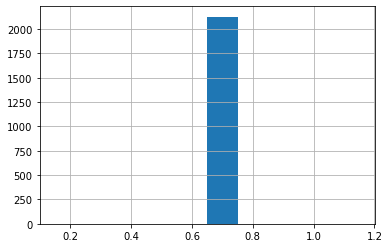

In [41]:
df['accumulation_intensity'].hist()

In [137]:
df.sample(4)

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP,accumulation_intensity
SegFile,,,,,,,,,,,,,,,,,,,,,,,,,
CTG0203.txt,120.0,120.0,0.0,4.0,0.0,54.0,0.6,12.0,8.6,0.0,0.0,0.0,24.0,109.0,133.0,0.0,1.0,123.0,122.0,124.0,1.0,0.0,1.0,1.0,0.616045
CTG1616.txt,137.0,137.0,2.0,45.0,1.0,64.0,1.9,0.0,6.9,2.0,0.0,0.0,76.0,96.0,172.0,4.0,0.0,142.0,130.0,143.0,5.0,0.0,1.0,1.0,0.616045
CTG1176.txt,126.0,126.0,3.0,0.0,5.0,29.0,1.3,0.0,9.2,0.0,0.0,0.0,65.0,103.0,168.0,2.0,0.0,127.0,134.0,133.0,18.0,0.0,2.0,1.0,0.616045
CTG1222.txt,135.0,135.0,0.0,0.0,5.0,50.0,0.6,0.0,12.2,0.0,0.0,0.0,34.0,118.0,152.0,0.0,0.0,137.0,136.0,138.0,1.0,0.0,1.0,1.0,0.616045
